In [38]:
# Drift diffusion model 
# August 2020, Clara Kuper

# This script implements noise free drift diffusion models that simulate the selection of action plans.
# Three different models will be implemented

# 1. The drift rate of a decision is set when 75% certainty about the distribution are reached, then, the action is executed
# 2. The drift rate is initiated at the first step, and changed with every new incoming information
# 3. The drift rate is initiated at the first step, but changed only when the new incoming information requires a different decision (change of mind)


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import uniform

df = pd.read_csv('sim1000.csv')
df

,Unnamed: 0,trial,time,y_attacker,x_attacker,y_end_attacker,x_target,y_target,goal_mean,goal_upper,goal_lower,p_in,goal_upper_expand,goal_lower_expand,decision_expand,d_prime_expand
0,0,0.0,0.008333,-5.5,-20.00,-5.5,0.0,1.731510,0.0,4.0,-4.0,0.095874,1.731510,1.731510,correct_reject,0.0
1,1,0.0,0.054444,-5.5,-18.75,-5.5,0.0,-1.818140,0.0,4.0,-4.0,0.172343,1.731510,-1.818140,correct_reject,0.0
2,2,0.0,0.100556,-5.5,-17.50,-5.5,0.0,2.226061,0.0,4.0,-4.0,0.068870,2.226061,-1.818140,correct_reject,0.0
3,3,0.0,0.146667,-5.5,-16.25,-5.5,0.0,2.371570,0.0,4.0,-4.0,0.033312,2.371570,-1.818140,correct_reject,0.0
4,4,0.0,0.192778,-5.5,-15.00,-5.5,0.0,0.740505,0.0,4.0,-4.0,0.033312,2.371570,-1.818140,correct_reject,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,11,999.0,0.515556,5.5,-6.25,5.5,0.0,1.295679,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15996,12,999.0,0.561667,5.5,-5.00,5.5,0.0,-1.010079,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15997,13,999.0,0.607778,5.5,-3.75,5.5,0.0,2.134271,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0
15998,14,999.0,0.653889,5.5,-2.50,5.5,0.0,-2.166901,0.0,4.0,-4.0,0.000000,3.884249,-3.327805,correct_reject,0.0


In [2]:
# General stuff

boundary = 100
offset = 0

time_m1 = np.linspace(0,0.7,16) #this can be the same time vector as in the experiment (aligned to new info)
time_thresh = 0.4
dec_thresh = 0.25

# translation factor between p_in and drift rate.
# the translation factor ensures that when p_in is below 0.5 the decision boundary is not reached after 400 ms
# when p_in is above 0.5, the decision boundary is reached in 400 ms, else it stays below
# thus: scale_factor * 0.5 * 0.4 = boundary
# scale_factor = 100/(0.5 * 0.4)
scale_factor =  boundary/(dec_thresh * time_thresh)

# reshape evidence to include negative values
df['p_in'] = df['p_in']-0.5


In [3]:
# d' ratings of the mean, collapsing and expanding strategies
# compute d' curve time - d_prime
# evaluate which strategy performs best at which time, and if there is a difference at all

# how to compute d' 
def get_d_prime(hit, miss, fa, cr):
    
    # there must be at least one instance of each response type
    if hit == 0:
        hit = 1
    if miss == 0:
        miss = 1
    
    if fa == 0:
        fa = 1
    if cr == 0:
        cr =1
    
    # compute rates
    hit_rate = hit/(hit+miss)
    fa_rate = fa/(fa+cr)
        
    return stats.norm.ppf(hit_rate)- stats.norm.ppf(fa_rate)

In [4]:
def get_response_type(data, t_cross):
    if abs(data["y_attacker"].iloc[-1])<4:
        attacker = 'hit'
    else:
        attacker = 'miss'

    if 0.4 > t_cross and t_cross > 0:
        response = 'go'
    else: 
        response = 'nogo'

    if attacker == 'hit': 
        if response == 'go':
            trial_class ='hit'
        else:
            trial_class = 'miss'
    else:
        if response == 'go':
            trial_class = 'fa'
        else:
            trial_class = 'cr'
    return trial_class

In [5]:
# Model one: when certainty x is reached, the response is initiated, or when the time expires
# params to be fitted: scale_factor/threshold for decision, offset, evidence_thresh

evidence_thresh = 0.3

params_m1 = {'boundary':boundary, 'offset':offset, 'time':time_m1, 'scale_factor':scale_factor, 'evidence_thresh':evidence_thresh}

def simulate_m1(params,data):
    
        """
        Simulates go/no-go decisions based on the data presented in "data"
        input: 
        params: boundary, offset, time (time needs to have the same dt as the information update stream), dec_thresh, scale_factor 
        data
        
        output:
        table (n_trials x time): value of drift over time
        rea_correct: table with reaction times and decisions
        """
        # how many trials?
        trials = np.unique(data['trial'])
        # how many time steps do we look at?
        N_time = len(params['time'])
        # the difference between two time steps
        dt = np.unique(np.diff(data['time']))[-1]
        
        # set the output tables
        out_table = np.zeros((len(trials),N_time))
        rea_correct = np.zeros((len(trials),2))
        rea_correct = pd.DataFrame(rea_correct)
        
        # set the basic parameters:
        boundary = params['boundary']
        scale_factor = params['scale_factor']
        out_table[:,0] = params['offset']
        
        for trial in trials:
            # here, we compute the drift behaviour
            # find all relevant trials
            trial_data = data.iloc[np.where(data['trial']==trial)[0]]
            # get the points when the threshold was crossed
            above_thresh = np.where(abs(trial_data["p_in"])>params['evidence_thresh'])[0]
            drift_indicator = np.zeros(N_time)
            if len(above_thresh)>0:
                # if not empty, set all drift values after that to the first value
                drift_rate = trial_data["p_in"].iloc[min(above_thresh)] * scale_factor
                drift_indicator[min(above_thresh):] = drift_rate
            else:
                drift_rate = 0
            
            for t_id, t in enumerate(params['time'][:-1]):
                # compute the evidence at each time
                out_table[int(trial),t_id+1] = out_table[int(trial),t_id] + drift_indicator[t_id] * dt
           
            # compute the time it takes to cross the threshold value
            try:
                t_cross = boundary/drift_rate
            except ZeroDivisionError:
                t_cross = -0.01
            rea_correct.iloc[int(trial),0] = t_cross
            
            # write out the response type (hit, miss, cr, fa)
            rea_correct.iloc[int(trial),1] = get_response_type(trial_data, t_cross)
            
        return out_table, rea_correct
        
simulated_drift, rea_correct_m1 = simulate_m1(params_m1,df)       

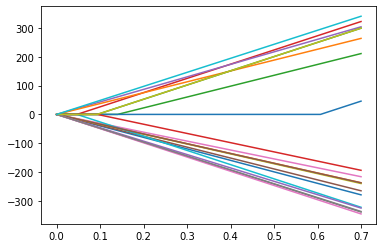

In [6]:
# plot drift rates

fig1, axs1 = plt.subplots(1)
for drift in range(0,20):
    axs1.plot(time_m1, simulated_drift[drift,])

(array([444.,   0.,   0., 416.,   0.,   0.,  84.,   0.,   0.,  56.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

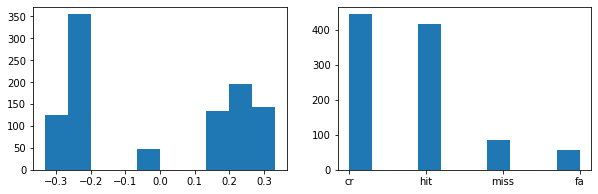

In [7]:
# plot reaction times and response proportion

fig2, axs2 = plt.subplots(1,2, figsize = (10,3))

axs2[0].hist(rea_correct_m1.iloc[:,0])
axs2[1].hist(rea_correct_m1.iloc[:,1])

In [8]:
hit = np.sum(rea_correct_m1.iloc[:,1]=='hit')
miss = np.sum(rea_correct_m1.iloc[:,1]=='miss')
fa = np.sum(rea_correct_m1.iloc[:,1]=='fa')
cr = np.sum(rea_correct_m1.iloc[:,1]=='cr')
d_prime_m1 = get_d_prime(hit, miss, fa, cr)

print('D-prime from model 1 is {}.'.format(d_prime_m1))

D-prime from model 1 is 2.178059173620461.


In [9]:
# Model one - one: fully naive model, the drift is initiated with the first frame
# params to be fitted:

params_m1_1 = {'boundary':boundary, 'offset':offset, 'time':time_m1, 'scale_factor':scale_factor}

def simulate_m1_1(params,data):
    
        """
        Simulates go/no-go decisions based on the data presented in "data"
        input: 
        params: boundary, offset, time (time needs to have the same dt as the information update stream), scale_factor 
        data
        
        output:
        table (n_trials x time): value of drift over time
        rea_correct: table with reaction times and decisions
        """
        # how many trials?
        trials = np.unique(data['trial'])
        # how many time steps do we look at?
        N_time = len(params['time'])
        # the difference between two time steps
        dt = np.unique(np.diff(data['time']))[-1]
        
        # set the output tables
        out_table = np.zeros((len(trials),N_time))
        rea_correct = np.zeros((len(trials),2))
        rea_correct = pd.DataFrame(rea_correct)
        
        # set the basic parameters:
        boundary = params['boundary']
        scale_factor = params['scale_factor']
        out_table[:,0] = params['offset']
        
        for trial in trials:
            # here, we compute the drift behaviour
            # find all relevant trials
            trial_data = data.iloc[np.where(data['trial']==trial)[0]]
            #drift_indicator = np.zeros(N_time)
            drift_rate = trial_data["p_in"].iloc[0] * scale_factor
            
            for t_id, t in enumerate(params['time'][:-1]):
                # compute the evidence at each time
                out_table[int(trial),t_id+1] = out_table[int(trial),t_id] + drift_rate * dt
           
            # compute the time it takes to cross the threshold value
            try:
                t_cross = boundary/drift_rate
            except ZeroDivisionError:
                t_cross = -0.01
            rea_correct.iloc[int(trial),0] = t_cross
            
            # write out the response type (hit, miss, cr, fa)
            rea_correct.iloc[int(trial),1] = get_response_type(trial_data, t_cross)
            
        return out_table, rea_correct
        
simulated_drift_m1_1, rea_correct_m1_1 = simulate_m1_1(params_m1_1,df)  

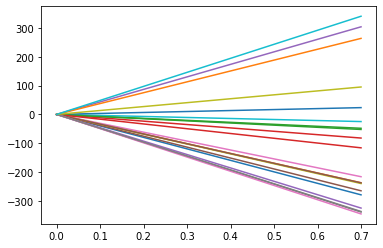

In [10]:
# plot drift rates

fig1_1, axs1_1 = plt.subplots(1)
for drift in range(0,20):
    axs1_1.plot(time_m1, simulated_drift_m1_1[drift,])

(array([439.,   0.,   0., 297.,   0.,   0., 203.,   0.,   0.,  61.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

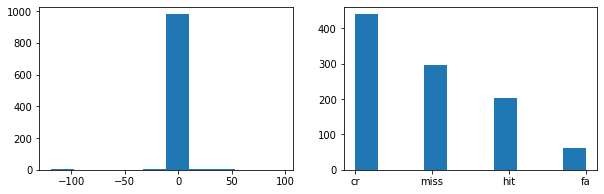

In [11]:
# plot reaction times and response proportion

fig2_1, axs2_1 = plt.subplots(1,2, figsize = (10,3))

axs2_1[0].hist(rea_correct_m1_1.iloc[:,0])
axs2_1[1].hist(rea_correct_m1_1.iloc[:,1])

In [12]:
hit = np.sum(rea_correct_m1_1.iloc[:,1]=='hit')
miss = np.sum(rea_correct_m1_1.iloc[:,1]=='miss')
fa = np.sum(rea_correct_m1_1.iloc[:,1]=='fa')
cr = np.sum(rea_correct_m1_1.iloc[:,1]=='cr')
d_prime_m1_1 = get_d_prime(hit, miss, fa, cr)

print('D-prime from model 1_1 is {}.'.format(d_prime_m1_1))

D-prime from model 1_1 is 0.927200226887853.


In [13]:
## model two: every new information changes the drift rate 
# the drift is put on hold for a brief moment when new information comes in
# params to be fitted: mu_1, sd_1, offset, scale_factor

# parameters for putting the motor plan on hold
mu_1 = 0.02
sd_1 = 0.005

map_stim_time = 20
stim_updates = len(np.unique(df['time']))

time_m2 = np.linspace(0, 0.7, map_stim_time*stim_updates)
params_m2 = {'boundary':boundary, 'offset':offset, 'time':time_m2, 'scale_factor':scale_factor, 'map_factor': map_stim_time, 'mu_1': mu_1, 'sd_1':sd_1}


def simulate_m2(params, data):
    """
    runs a drift diffusion process that is interupted and re-evaluated with every new bit of information
    params:
    
    """
    
    # unpack the parameters
    boundary = params['boundary']
    offset = params['offset']
    time = params['time']
    drift_factor = params['scale_factor']
    map_factor = params['map_factor']
    mu_1 = params['mu_1']
    sd_1 = params['sd_1']
    
    # unpack data driven parameters
    trials = np.unique(data['trial'])
    trial_N = len(trials)
    time_N = len(time)
    
    # define the output tables
    drift_table = np.zeros((trial_N,time_N))
    rea_correct = np.zeros((trial_N, 2))
    rea_correct = pd.DataFrame(rea_correct)
    
    # define dt for time and stimulus updates
    dt_time = np.unique(np.diff(time))[-1]
    dt_stim = np.unique(np.diff(data['time']))[-1]
    
    # loop through trials and comupte the drift
    for trial in trials:
        # get only trial related data
        trial_data = data.iloc[np.where(data['trial']==trial)[0]]
        stim_time = trial_data['time']
        
        drift_vector = np.zeros(time_N)
        # challenge: write the drift rate vector
        drift_old = 0
        for idx, tim in enumerate(stim_time):
            # create a batch that matches the length of the associated update vector, add that to the vector
            # create an empty vector to store the update values
            mapped_vec = np.zeros(map_factor)
            stop_race_t = np.random.normal(mu_1, sd_1)
            stop_race_f = int(stop_race_t/dt_time)
            # draw a resting time from a random normal distribution
            drift = trial_data['p_in'].iloc[idx]*drift_factor
            #if drift != drift_old:
            mapped_vec[int(stop_race_f):] = drift
            #else:
            #    mapped_vec[:] = drift
                
            # where in the drift vector does that go?
            idx_to_drift = idx*map_factor
            drift_vector[idx_to_drift:idx_to_drift+map_factor] = mapped_vec
            drift_old = drift
        
        # take that drift vector to compute the actual updates in the system:
        for t, drift in enumerate(drift_vector[:-1]):
            drift_table[int(trial),t+1] = drift_table[int(trial),t] + drift*dt_time
            
        # with the drift table, compute the reaction times and correct/incorrect responses
        # crossing time is read out this time instead of computed
        # the frame when the boundary was crossed
        try:
            f_cross = min(np.where(drift_table[int(trial),:]>boundary)[0])
            t_cross = f_cross * dt_time
        except ValueError:
            t_cross = -0.01
        rea_correct.iloc[int(trial),0] = t_cross

        # write out the response type (hit, miss, cr, fa)
        rea_correct.iloc[int(trial),1] = get_response_type(trial_data, t_cross)
    return drift_table, rea_correct
        
drift_m2, rea_correct_m2 = simulate_m2(params_m2, df)           

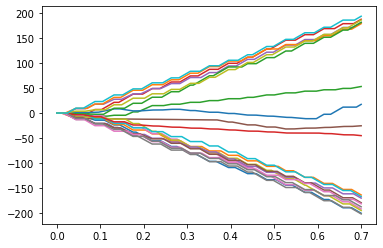

In [14]:
fig3, axs3 = plt.subplots(1)

for ix in range(0,20):
    axs3.plot(time_m2, drift_m2[ix,:])

(array([500.,   0.,   0.,   0.,   0., 360.,   0.,   0.,   0., 140.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

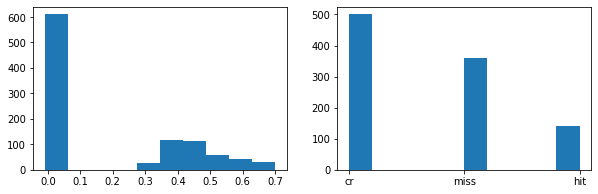

In [15]:
# plot reaction times and response proportion

fig4, axs4 = plt.subplots(1,2, figsize = (10,3))

axs4[0].hist(rea_correct_m2.iloc[:,0])
axs4[1].hist(rea_correct_m2.iloc[:,1])

In [16]:
hit = np.sum(rea_correct_m2.iloc[:,1]=='hit')
miss = np.sum(rea_correct_m2.iloc[:,1]=='miss')
fa = np.sum(rea_correct_m2.iloc[:,1]=='fa')
cr = np.sum(rea_correct_m2.iloc[:,1]=='cr')
d_prime_m2 = get_d_prime(hit, miss, fa, cr)

print('D-prime from model 2 is {}.'.format(d_prime_m2))

D-prime from model 2 is 2.2959504393925547.


In [17]:
def is_CoM(old_d, new_d):   
    if not np.sign(old_d) == np.sign(new_d):
        return True
    elif old_d == 0:
        return True
    else:
        return False 
    

In [18]:
## model three: Decision are updated ONLY if the new evidence is strongly suggesting a different outcome
# the drift is put on hold for a brief moment when new information comes in
# params to be fitted: mu_1, sd_1, offset, scale_factor

# parameters for putting the motor plan on hold
mu_1 = 0.02
sd_1 = 0.005

map_stim_time = 20
stim_updates = len(np.unique(df['time']))

time_m3 = np.linspace(0, 0.7, map_stim_time*stim_updates)
params_m3 = {'boundary':boundary, 'offset':offset, 'time':time_m3, 'scale_factor':scale_factor, 'map_factor': map_stim_time, 'mu_1': mu_1, 'sd_1':sd_1}


def simulate_m3(params, data):
    """
    runs a drift diffusion process that is interupted and re-evaluated with every new bit of information
    params:
    
    """
    
    # unpack the parameters
    boundary = params['boundary']
    offset = params['offset']
    time = params['time']
    drift_factor = params['scale_factor']
    map_factor = params['map_factor']
    mu_1 = params['mu_1']
    sd_1 = params['sd_1']
    
    # unpack data driven parameters
    trials = np.unique(data['trial'])
    trial_N = len(trials)
    time_N = len(time)
    
    # define the output tables
    drift_table = np.zeros((trial_N,time_N))
    rea_correct = np.zeros((trial_N, 2))
    rea_correct = pd.DataFrame(rea_correct)
    
    # define dt for time and stimulus updates
    dt_time = np.unique(np.diff(time))[-1]
    dt_stim = np.unique(np.diff(data['time']))[-1]
    
    # loop through trials and comupte the drift
    for trial in trials:
        # get only trial related data
        trial_data = data.iloc[np.where(data['trial']==trial)[0]]
        stim_time = trial_data['time']
        
        drift_vector = np.zeros(time_N)
        # challenge: write the drift rate vector
        old_drift = 0
        for idx, tim in enumerate(stim_time):
            # create a batch that matches the length of the associated update vector, add that to the vector
            # create an empty vector to store the update values
            mapped_vec = np.zeros(map_factor)
            stop_race_t = np.random.normal(mu_1, sd_1)
            stop_race_f = int(stop_race_t/dt_time)
            # draw a resting time from a random normal distribution
            new_drift = trial_data['p_in'].iloc[idx]*drift_factor
            if is_CoM(old_drift, new_drift):
                drift = new_drift
                mapped_vec[int(stop_race_f):] = drift
            else:
                mapped_vec[:] = drift
                
            # where in the drift vector does that go?
            idx_to_drift = idx*map_factor
            drift_vector[idx_to_drift:idx_to_drift+map_factor] = mapped_vec
            old_drift = drift
        
        # take that drift vector to compute the actual updates in the system:
        for t, drift in enumerate(drift_vector[:-1]):
            drift_table[int(trial),t+1] = drift_table[int(trial),t] + drift*dt_time
            
        # with the drift table, compute the reaction times and correct/incorrect responses
        # crossing time is read out this time instead of computed
        # the frame when the boundary was crossed
        try:
            f_cross = min(np.where(drift_table[int(trial),:]>boundary)[0])
            t_cross = f_cross * dt_time
        except ValueError:
            t_cross = -0.01
        rea_correct.iloc[int(trial),0] = t_cross

        # write out the response type (hit, miss, cr, fa)
        rea_correct.iloc[int(trial),1] = get_response_type(trial_data, t_cross)
    return drift_table, rea_correct
        
drift_m3, rea_correct_m3 = simulate_m3(params_m3, df)           

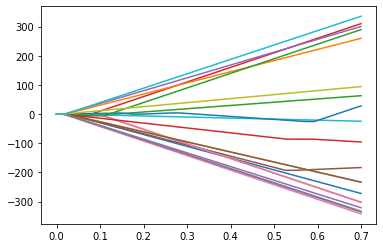

In [19]:
fig5, axs5 = plt.subplots(1)

for ix in range(0,20):
    axs5.plot(time_m3, drift_m3[ix,:])

(array([489.,   0.,   0., 231.,   0.,   0., 269.,   0.,   0.,  11.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

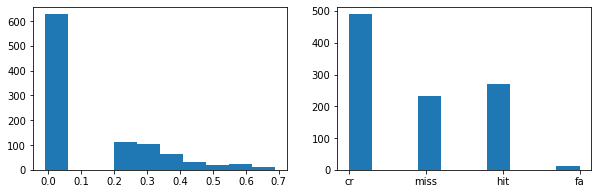

In [20]:
# plot reaction times and response proportion

fig6, axs6 = plt.subplots(1,2, figsize = (10,3))

axs6[0].hist(rea_correct_m3.iloc[:,0])
axs6[1].hist(rea_correct_m3.iloc[:,1])

In [21]:
hit = np.sum(rea_correct_m3.iloc[:,1]=='hit')
miss = np.sum(rea_correct_m3.iloc[:,1]=='miss')
fa = np.sum(rea_correct_m3.iloc[:,1]=='fa')
cr = np.sum(rea_correct_m3.iloc[:,1]=='cr')
d_prime_m3 = get_d_prime(hit, miss, fa, cr)

print('D-prime from model 3 is {}.'.format(d_prime_m3))

D-prime from model 3 is 2.109487181075031.
